In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
import re
import string

In [2]:
pd_data_train = pd.read_csv('train.csv')

Exploration

In [3]:
# print(f'keyword NaN count: {(x["keyword"] == 0).sum()}')
# print(f'locations NaN count: {(x["location"] == 0).sum()}')
# print(f'Total disasters: {pd_data_train["target"].sum()}')
# print(f'Total non-disasters: {(pd_data_train["target"] == 0 ).sum()}')
# keywords_nan_target_1 = pd_data_train[(pd_data_train['target'] == 1) & (pd_data_train['keyword'] == 0)].shape[0]
# keywords_nan_target_0 = pd_data_train[(pd_data_train['target'] == 0) & (pd_data_train['keyword'] == 0)].shape[0]
# location_nan_target_1 = pd_data_train[(pd_data_train['target'] == 1) & (pd_data_train['location'] == 0)].shape[0]
# location_nan_target_0 = pd_data_train[(pd_data_train['target'] == 0) & (pd_data_train['location'] == 0)].shape[0]

In [4]:
# disasters = pd_data_train.loc[pd_data_train['target'] ==1].to_numpy()
# non_disasters = pd_data_train.loc[pd_data_train['target'] == 0].to_numpy()
# non_disasters = non_disasters[np.random.choice(non_disasters.shape[0], len(disasters)+1, replace=False)]
# balanced_data = np.concatenate((disasters,non_disasters))
# np.random.shuffle(balanced_data)

In [5]:
# x_np = balanced_data[:,3:]
# y_np = balanced_data[:,4:5].astype('float32')

In [6]:
train_data = pd_data_train.drop(columns=['location','id', 'keyword'])
train_data = train_data.fillna(0)
train_data['text'] = train_data['text'].apply(lambda text: re.sub('[^\w]', ' ',text) )

In [7]:
Y = train_data['target'].to_numpy()
X = train_data.drop(columns=['target']).to_numpy()
x_text = X[:,0:1]

re-sample the data to balance the classes

In [8]:
tfidf = TfidfVectorizer(ngram_range=(1,1))
x_preprocessed = []
for i in range(len(x_text)):
    # print(x_text[i:i+1][0][0])
    tokens = x_text[i:i+1][0][0].split()
    tokens = [i.lower() for i in tokens]
    tokens = [i.translate(str.maketrans('', '', string.punctuation)) for i in tokens]
    tokens = [re.sub("\s+", " ", i) for i in tokens]
    x_preprocessed.append(" ".join(tokens))
x_tf = tfidf.fit_transform(x_preprocessed).toarray()
x = np.concatenate((x_tf, X[:,1:]), axis=1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.25, random_state=21)
y_train = y_train.flatten()

d:\kaggle_competitions\nlp-getting-started\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Stacking classifier Accuracy: 81.61764705882352


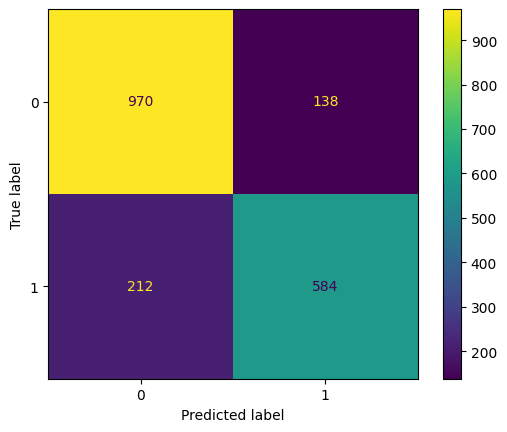

In [10]:
estimators = []
estimators.append(('lr',LogisticRegression()))
estimators.append(('lsvm',LinearSVC()))
estimators.append(('nb',MultinomialNB()))

stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack_model.fit(x_train, y_train)
stack_preds = stack_model.predict(x_test)
stack_errs = np.sum(stack_preds != y_test.flatten())
print(f'Stacking classifier Accuracy: {(1 - stack_errs / len(x_test)) * 100}')
plot_confusion_matrix(stack_model, x_test, y_test)

Preparing submission

In [11]:
test_data = pd.read_csv('test.csv')
test_data = test_data.drop(columns=['location', 'keyword'])
test_data = test_data.fillna(0)
test_data['text'] = test_data['text'].apply(lambda text: re.sub('[^\w]', ' ',text) )
x_test_text = test_data['text'].to_numpy()
x_sub_processed = []
for i in range(len(x_test_text)):
    toks = x_test_text[i:i+1][0].split()
    toks = [i.lower() for i in toks]
    toks = [i.translate(str.maketrans('', '', string.punctuation)) for i in toks]
    toks = [re.sub("\s+", " ", i) for i in toks]
    x_sub_processed.append(" ".join(toks))

x_sub_tf = tfidf.transform(x_sub_processed).toarray()
test_x = test_data.to_numpy()
sub_preds = stack_model.predict(x_sub_tf)
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['target'] = sub_preds


In [12]:
submission.to_csv('stacking_2.csv', index=False)